In [1]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR


# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda


import os

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# Data Processing

In [4]:
# importing train.csv data and modifying entries to remove duplicate and reset index

eeg_y = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
eeg_y = eeg_y.drop_duplicates(subset='eeg_id', keep='first') # There are duplicate entries in the csv for different timestamps. For our case we can just take the first occurance.
eeg_y = eeg_y.reset_index(drop=True) # Index will be fragmented after dropping duplicate, so we reassign each entry a new index starting from 0 to n.        

# split eeg_y into train and test split
eeg_train_val_y, eeg_test_y = train_test_split(eeg_y, test_size=0.2, shuffle=True)
eeg_train_y, eeg_val_y = train_test_split(eeg_train_val_y, test_size=0.2, shuffle=True)

eeg_train_y = eeg_train_y.reset_index(drop=True)
eeg_val_y = eeg_val_y.reset_index(drop=True)
eeg_test_y = eeg_test_y.reset_index(drop=True)


print(eeg_train_y.head())
print(eeg_train_y.shape)
print(eeg_test_y.shape)


       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0   793749164           0                       0.0       274488772   
1   502637676           0                       0.0       646309005   
2  2102314742           0                       0.0       169375920   
3  2636836171           0                       0.0      1951122771   
4   443208604           0                       0.0       738504145   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0  3051157163   
1                   0                               0.0  3715059670   
2                   2                             490.0  2369405757   
3                   0                               0.0  2831926558   
4                   0                               0.0  1174462393   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       33550          Seizure             3         0         0   

In [5]:
# import eeg data as dictionary from dict notebook
# This is a lot faster than loading the data from kaggle into a new dictionary.
eeg_data_dict = {}
with open('/kaggle/input/notebook01c73f822d/saved_eeg_dict.pkl', 'rb') as f:
    eeg_data_dict = pickle.load(f)

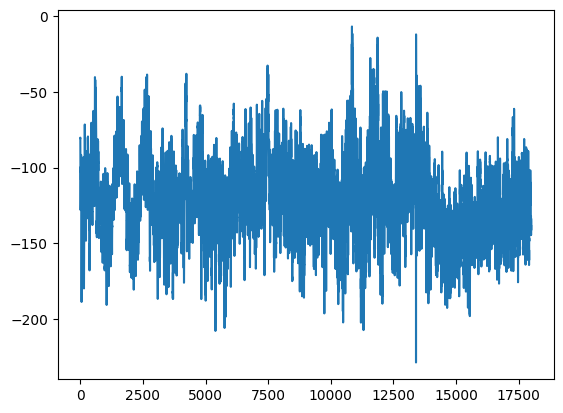

(18000,)


In [6]:
# plot unfiltered and un-normalized data
plt.plot(next(iter(eeg_data_dict.values()))[:, 0])
plt.show()
print(next(iter(eeg_data_dict.values()))[:, 0].shape)

In [7]:
print(len(eeg_data_dict))
print(eeg_data_dict[568657])
print(len(eeg_data_dict[568657][0]))
print(len(eeg_data_dict[568657][1]))
print(len(eeg_data_dict[568657][2]))

print("hi")

17089
[[ -75.36   92.37   65.47 ...  -42.16  121.24   72.55]
 [-107.74   59.07   32.59 ...  -80.43   88.4    40.25]
 [-103.05   50.95   10.75 ...  -93.09   51.69   31.82]
 ...
 [-141.6   -47.55 -120.6  ... -145.94    2.19  -19.32]
 [-155.55  -60.48 -116.54 ... -138.28   28.15  -21.1 ]
 [-184.43 -107.31 -161.08 ... -169.9   -15.49  -55.96]]
8
8
8
hi


In [8]:
# apply frequency filter to eeg data
# Keep frequency within 1hz to 40hz
sos = signal.butter(3, [0.5, 40], 'bandpass', fs=200, output='sos') # this is the filter, we will apply it below with signal.sosfilt()

## Dataset and Dataloader

In [9]:
def plotEEG(eeg, offset=1):
    eeg_plt = eeg
    
#     columns = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
#        'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']
    columns = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
    
    fig, ax = plt.subplots(figsize=(16,6))
    for i, column in enumerate(columns):
        ax.plot(eeg_plt[i] + i * offset, linewidth=1.0, color="darkslategray")

    ax.set_yticks(np.arange(len(columns)) * offset)
    ax.set_yticklabels(columns)

    plt.show()

In [10]:
# Custom dataset
class EEGDataset(Dataset):
    def __init__(self, eeg_y, eeg_data_dict, dim):
        self.eeg_labels = eeg_y
        self.eeg_data_dict = eeg_data_dict
        self.dim = dim
    
    def __len__(self): # number of samples in our dataset
        return len(self.eeg_labels)
    
    def __getitem__(self, idx): # loads and returns a sample at index idx.
        # convert votes to probability distribution vector
        votes = self.eeg_labels.loc[idx, ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].to_numpy()
        total_vote = np.sum(votes)
        label = votes / total_vote
        label = torch.tensor(np.array(label, dtype=np.float32))
        
        row = self.eeg_labels.iloc[idx]
        eeg_id = row['eeg_id']
#         print(eeg_id)
        eeg = self.eeg_data_dict[eeg_id]
        
#         print(eeg.shape)
#         plt.figure()
#         plt.plot(eeg[0:1000, 0])
#         plt.show()
        
        
        # we need to crop the eeg to 50 seconds, starting from the offset specified in eeg_label_offset_seconds
        offset_index = int(self.eeg_labels.loc[idx, 'eeg_label_offset_seconds']) * 200
        end_index = offset_index + 10000
        eeg = eeg[offset_index: end_index, ] # select 50 second of data 
        
#         print("cropped eeg")
#         plotEEG(eeg.transpose(1,0), 200)

        eeg = np.nan_to_num(eeg, nan=0.0)
        # apply sosfilt and minmax normalization to eeg data

        sos_eeg = signal.sosfilt(sos, eeg, axis=0)
        
#         print("after sos filter")
#         plotEEG(sos_eeg.transpose(1,0), 200)
        
        normalized_eeg = minmax_scale(sos_eeg.transpose(1, 0), (0,1))
    
#         print("after min max")
#         plotEEG(normalized_eeg, 0.5)
        
        if self.dim == '1d':
            normalized_eeg = torch.tensor(normalized_eeg)
        elif self.dim == '2d':
            normalized_eeg = np.expand_dims(normalized_eeg, axis=0)
            normalized_eeg = torch.tensor(normalized_eeg)
        else:
            raise("Invalid dimension")
        
        return normalized_eeg, label

torch.Size([8, 10000]) tensor([0., 1., 0., 0., 0., 0.])


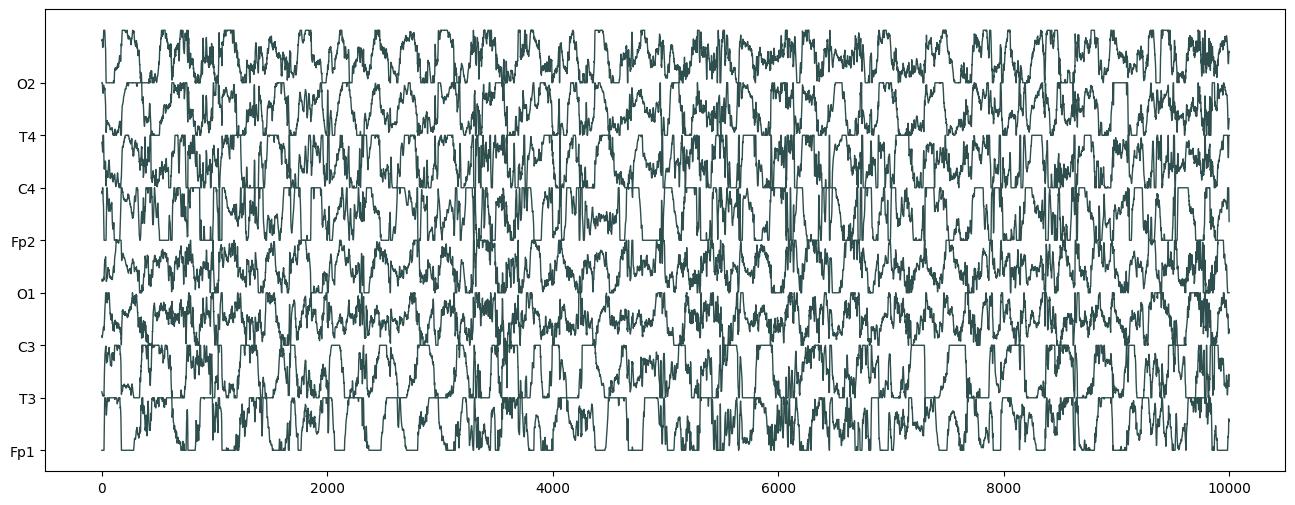

In [11]:
eeg_train_data_set = EEGDataset(eeg_train_y, eeg_data_dict, '1d')
eeg_val_data_set = EEGDataset(eeg_val_y, eeg_data_dict, '1d')
eeg_test_data_set = EEGDataset(eeg_test_y, eeg_data_dict, '1d')
normalized_eeg, label = eeg_train_data_set[5]
print(normalized_eeg.shape, label)
plotEEG(normalized_eeg)

In [12]:
# Dataloader
# Purpose: split the dataset up into mini batches because the hardware cannot store tens of thoasands of data in memory at one time.
train_dataloader = DataLoader(eeg_train_data_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(eeg_val_data_set, batch_size=64, shuffle=False)
test_dataloader = DataLoader(eeg_test_data_set, batch_size=64, shuffle=False)

In [13]:
# plt.plot(normalized_eeg)
# plt.show()

In [14]:
# print(train_dataloader)
# print(len(train_dataloader))

# Convolution Neural Network

In [15]:
class ConvolutionNeuralNetwork1D(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__() # Inherit from nn.Module
        
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html <-- Conv1d documentation
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            # Modified VGG-19 model for 1D convolution
            
            # block1: 2 conv - 1 maxpool
            nn.Conv1d(8, 64, kernel_size=3, padding=1), # 8 = number of channels
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            # block2: 2 conv - 1maxpool
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            # block3: 4 conv - 1 maxpool
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            # block4: 4 conv - 1 maxpool
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            # block5: 4 conv - 1 maxpool
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        
#         self.avgpool = nn.AdaptiveAvgPool1d(7)

        self.classifier = nn.Sequential(
            nn.Linear(159744, 4096),
            nn.ReLU(inplace=True),
#             nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
#             nn.Dropout(),
            nn.Linear(1000, num_classes),
        )
    
    def forward(self, x: torch.Tensor):
        x = self.layer_stack(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten starting from the second dimension
        logits = self.classifier(x)
    
        return logits

    

In [16]:
# class ConvolutionNeuralNetwork2D(nn.Module):
#     def __init__(self, num_classes=6):
#         super(ConvolutionNeuralNetwork2D, self).__init__() # Inherit from nn.Module
        
#         # https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html <-- Conv1d documentation
#         self.flatten = nn.Flatten()
#         self.layer_stack = nn.Sequential(
#             # Modified VGG-19 model for 1D convolution
            
#             # input: 1 x 8 x 10000
#             # block1: 2 conv - 1 maxpool
#             nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1), 
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2), padding=1), # 64 x 8 x 5000
            
#             # block2: 2 conv - 1maxpool
#             nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2), padding=1), # 128 x 8 x 2500
            
#             # block3: 4 conv - 1 maxpool
#             nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2), padding=1), # 256 x 8 x 1250
            
#             # block4: 4 conv - 1 maxpool
#             nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2)), # 512 x 4 x 625
            
#             # block5: 4 conv - 1 maxpool
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2)), # 512 x 2 x 312
#         )
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

#         self.classifier = nn.Sequential(
#             nn.Linear(512, 64),
#             nn.ReLU(inplace=True),
# #             nn.Dropout(),
#             nn.Linear(64, num_classes),
#         )
    
#     def forward(self, x: torch.Tensor):
#         x = self.layer_stack(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1) # Flatten starting from the second dimension
#         logits = self.classifier(x)
    
#         return logits

    

In [17]:
class BasicBlock(nn.Module):
    expansion: int = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(8, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def resnet18_1d():
    """Constructs a ResNet-18 model."""
    model = ResNet1D(BasicBlock, [2, 2, 2, 2]) 
    return model



In [18]:
# # from pytorch resnet.py

# def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1):
#     """3x3 convolution with padding"""
#     return nn.Conv1d(
#         in_planes,
#         out_planes,
#         kernel_size=3,
#         stride=stride,
#         padding=dilation,
#         groups=groups,
#         bias=False,
#         dilation=dilation,
#     )

# def conv1x1(in_planes: int, out_planes: int, stride: int = 1):
#     """1x1 convolution"""
#     return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# class BasicBlock(nn.Module):
#     expansion: int = 1
    
#     def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1):
#         super().__init__()
        
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm1d(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm1d(planes)
#         self.downsample = downsample
#         self.stride = stride
    
#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

# class Bottleneck(nn.Module):
#     # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
#     # while original implementation places the stride at the first 1x1 convolution(self.conv1)
#     # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
#     # This variant is also known as ResNet V1.5 and improves accuracy according to
#     # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

#     expansion: int = 4

#     def __init__(self,
#                 inplanes,
#                 planes,
#                 stride=1,
#                 downsample=None,
#                 groups=1,
#                 base_width=64,
#                 dilation=1):
#         super().__init__()
#         width = int(planes * (base_width / 64.0)) * groups
        
#         # Both self.conv2 and self.downsample layers downsample the input when stride != 1
#         self.conv1 = conv1x1(inplanes, width)
#         self.bn1 = nn.BatchNorm1d(width)
#         self.conv2 = conv3x3(width, width, stride, groups, dilation)
#         self.bn2 = nn.BatchNorm1d(width)
#         self.conv3 = conv1x1(width, planes * self.expansion)
#         self.bn3 = nn.BatchNorm1d(planes * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out

# class ResNet(nn.Module):
#     def __init__(self,
#                 block,
#                 layers,
#                 num_classes: int = 6,
#                 zero_init_residual: bool = False,
#                 groups: int = 1,
#                 width_per_group: int = 64,) -> None:
#         super().__init__()

#         norm_layer = nn.BatchNorm1d
#         self._norm_layer = norm_layer

#         self.inplanes = 64
#         self.dilation = 1
#         replace_stride_with_dilation = [False, False, False]
#         self.groups = groups
#         self.base_width = width_per_group
        
#         self.conv1 = nn.Conv1d(8, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
# #         self.conv1 = MultiHeadConv1D(in_channels=8, out_channels=16, kernel_sizes=[3, 7, 11, 15])
#         self.bn1 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
#         self.avgpool = nn.AdaptiveAvgPool1d(1)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
#             elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck) and m.bn3.weight is not None:
#                     nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
#                 elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
#                     nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
    
#     def _make_layer(self,
#                     block,
#                     planes: int,
#                     blocks: int,
#                     stride: int = 1,
#                     dilate: bool = False) -> nn.Sequential:
#         norm_layer = self._norm_layer
#         downsample = None
#         previous_dilation = self.dilation
#         if dilate:
#             self.dilation *= stride
#             stride = 1
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
#             )

#         layers = []
#         layers.append(
#             block(
#                 self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation,
#             )
#         )
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(
#                 block(
#                     self.inplanes,
#                     planes,
#                     groups=self.groups,
#                     base_width=self.base_width,
#                     dilation=self.dilation
#                 )
#             )

#         return nn.Sequential(*layers)

#     def _forward_impl(self, x):
#         # See note [TorchScript super()]
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)

#         return x

#     def forward(self, x):
#         return self._forward_impl(x)

# def ResNet18():
#     return ResNet(BasicBlock, [2,2,2,2])

# def ResNet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])

# def ResNet50():
#     return ResNet(Bottleneck, [3, 4, 6, 3])

# Training Loop

In [19]:
# free_gpu_cache()

In [20]:
# eeg_train_dataset_2d = EEGDataset(eeg_train_y, eeg_data_dict, '2d')
# train_dataloader_2d = DataLoader(eeg_train_dataset_2d, batch_size=32, shuffle=True)
# train_eeg_batch_2d, train_labels_batch_2d = next(iter(train_dataloader_2d))
# print(f"EEG {train_eeg_batch_2d.shape}")
# print(f"Labels {train_labels_batch_2d.shape}")

In [21]:
# # 2d test

# CNN_2d_model = ConvolutionNeuralNetwork2D().to(device)
# print("model = ", CNN_2d_model)
# optimizer2d = torch.optim.Adam(CNN_2d_model.parameters(), lr=0.01) 

In [22]:
train_eeg_batch, train_labels_batch = next(iter(train_dataloader))
print(f"EEG {train_eeg_batch.shape}")
print(f"Labels {train_labels_batch.shape}")


EEG torch.Size([64, 8, 10000])
Labels torch.Size([64, 6])


In [23]:
model = ConvolutionNeuralNetwork1D().to(device)
print("model = ", model)

learning_rate = 0.01
criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

steps_per_epoch = len(train_dataloader)  # Number of batches per epoch
total_steps = steps_per_epoch * 4  # Total number of batches in all epochs
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

model =  ConvolutionNeuralNetwork1D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU(inplace=True)
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU(inplace=True)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU(inplace=True)
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU(inplace=True)
    (14): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): ReLU(inplace=True)
    (16): Conv1d(256, 256, 

In [24]:
def train_step(model, dataloader, criterion, optimizer, scheduler, device=device):
    model.train() # set model to training mode    
    train_loss = 0
    correct = 0
    total = 0
    for batch, (X, y) in enumerate(dataloader):
#     X, y = next(iter(dataloader))
        X, y = X.to(device), y.to(device)
        X = X.float()
    #     print(f"y: {y}")
        # zero the param gradients
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X)
        m = nn.LogSoftmax(dim=1)
        y_pred_log_softmax = m(y_pred)  # Apply softmax

        # calculate loss (per batch)
        loss = criterion(y_pred_log_softmax, y)
        train_loss += loss.item()

        # loss backward
        loss.backward()

        # optimize
        optimizer.step()
        
        # update learning rate
        scheduler.step()
        
        # calculate accuracy
        total += y.size(0)
        
        _, predicted = torch.max(y_pred.data, 1)
        _, labels = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
#         print(predicted, labels)

    train_loss /= len(dataloader)
    accuracy = 100 * correct/total
    print(f'Training Loss: {train_loss:.5f}, Accuracy: {accuracy:.2f}%')

In [25]:
def val_step(model, dataloader, criterion, device=device):
    model.eval() # set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # Ignore gradient tracking for validation
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.float()
            
            # forward pass
            y_pred = model(X)
            m = torch.nn.LogSoftmax(dim=1)
            y_pred_log_softmax = m(y_pred) # apply softmax
            
            # calculate loss (per batch)
            loss = criterion(y_pred_log_softmax, y)
            val_loss += loss.item()
            
            # calculate accuracy
            total += y.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            _, labels = torch.max(y, 1)
            correct += (predicted == labels).sum().item()
        
    val_loss /= len(dataloader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.5f}, Validation Accuracy: {accuracy:.2f}%')

In [26]:
num_epoch = 4
for epoch in range(1, num_epoch + 1):
    train_step(model, train_dataloader, criterion, optimizer, scheduler)
    val_step(model, val_dataloader, criterion)
    print(f"Epoch: {epoch}\n----------------------")

Training Loss: 130.55707, Accuracy: 33.62%
Validation Loss: 5.00708, Validation Accuracy: 10.24%
Epoch: 1
----------------------
Training Loss: 3.71330, Accuracy: 37.68%
Validation Loss: 1.26939, Validation Accuracy: 44.17%
Epoch: 2
----------------------
Training Loss: 1.29675, Accuracy: 41.40%
Validation Loss: 1.26854, Validation Accuracy: 44.17%
Epoch: 3
----------------------
Training Loss: 1.29592, Accuracy: 41.40%
Validation Loss: 1.26885, Validation Accuracy: 44.17%
Epoch: 4
----------------------


In [27]:
# num_epoch = 4
# criterion = nn.KLDivLoss(reduction="batchmean")
# for epoch in range(1, num_epoch + 1):
#     train_step(CNN_2d_model, train_dataloader_2d, criterion, optimizer2d)
#     print(f"Epoch: {epoch}\n----------------------")